In [1]:
%cd ..
%cd content
!wget -O data.zip https://zenodo.org/record/6757555/files/wGrapeUNIPD-DL%20dataset.zip?download=1
!unzip data.zip
!rm wGrapeUNIPD-DL\ dataset/Calibrated_Images/without_Conting/Chardonnay_BBCH75_20_06_20/_DSC8819.jpg
!rm wGrapeUNIPD-DL\ dataset/Calibrated_Images/without_Conting/Chardonnay_BBCH75_20_06_20/_DSC8819.txt
!rm wGrapeUNIPD-DL\ dataset/Calibrated_Images/with_Counting/Multiple_Cultivar_BBCH83_13_08_20/_counting.txt


/
/content
--2023-06-18 11:55:06--  https://zenodo.org/record/6757555/files/wGrapeUNIPD-DL%20dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2391373374 (2.2G) [application/octet-stream]
Saving to: ‘data.zip’

data.zip              0%[                    ]  10.68M   411KB/s    eta 93m 43s^C
Archive:  data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of data.zip or
        data.zip.zip, and cannot find data.zip.ZIP, period.
rm: cannot remove 'wGrapeUNIPD-DL dataset/Calibrated_Images/without_Conting/Chardonnay_BBCH75_20_06_20/_DSC8819.jpg': No such file or directory
rm: cannot remove

In [2]:
%cd ..
!rm -r /vision

!rm -r /datasets/grapes/
!mkdir /datasets
!rm -r /datasets/grapes/images_eval/

!mkdir /datasets/grapes/
!mkdir /datasets/grapes/images/
!mkdir /datasets/grapes/labels/train
!mkdir /datasets/grapes/images/train
!mkdir /datasets/grapes/images/val
!cp /content/wGrapeUNIPD-DL\ dataset/Calibrated_Images/*/*/*.txt /datasets/grapes/images/train/
!cp /content/wGrapeUNIPD-DL\ dataset/Calibrated_Images/*/*/*.jpg /datasets/grapes/images/train/
!cp /content/wGrapeUNIPD-DL\ dataset/Calibrated_Images/*/*/*.JPG /datasets/grapes/images/train/


!rm /datasets/grapes/images/train/_DSC8819.jpg


/
mkdir: cannot create directory ‘/datasets’: File exists
rm: cannot remove '/datasets/grapes/images_eval/': No such file or directory
mkdir: cannot create directory ‘/datasets/grapes/labels/train’: No such file or directory
rm: cannot remove '/datasets/grapes/images/train/_DSC8819.jpg': No such file or directory


In [9]:
%%shell
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.15.1

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 339090, done.
remote: Counting objects: 100% (74189/74189), done.
remote: Compressing objects: 100% (1316/1316), done.
remote: Total 339090 (delta 73414), reused 73490 (delta 72842), pack-reused 264901
Receiving objects: 100% (339090/339090), 682.51 MiB | 34.25 MiB/s, done.
Resolving deltas: 100% (312393/312393), done.
Note: switching to 'v0.15.1'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 42759b1cc8 Version number bump for vision (#7419)


In [16]:
!pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 509.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0.dev20230617+cpu
    Uninstalling torch-2.1.0.dev20230617+cpu:
      Successfully uninstalled torch-2.1.0.dev20230617+cpu
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0.dev20230617+cpu
    Uninstalling torchvision-0.16.0.dev20230617+cpu:
      Successfully uninstalled torchvision-0.16.0.dev20230617+cpu
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.1.0.dev20230617+cpu
    Uninstalling torchaudio-2.1.0.dev20230617+cpu:
      Successfully uninstalled torchaudio-2.1.0.dev20230617+cpu
ERROR: pip's 

In [4]:
!pip install -q -U albumentations
!pip3 install numpy --pre torch torchvision torchaudio --force-reinstall --extra-index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/nightly/cpu
  Using cached numpy-1.25.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
  Using cached https://download.pytorch.org/whl/nightly/cpu/torch-2.1.0.dev20230618%2Bcpu-cp310-cp310-linux_x86_64.whl (198.5 MB)
  Using cached https://download.pytorch.org/whl/nightly/cpu/torchvision-0.16.0.dev20230617%2Bcpu-cp310-cp310-linux_x86_64.whl (1.6 MB)
  Using cached https://download.pytorch.org/whl/nightly/cpu/torchaudio-2.1.0.dev20230617%2Bcpu-cp310-cp310-linux_x86_64.whl (2.6 MB)
  Using cached filelock-3.12.2-py3-none-any.whl (10 kB)
  Using cached typing_extensions-4.6.3-py3-none-any.whl (31 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached https://download.pytorch.org/whl/nightly/Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached fsspec-2023.6.0-py3-none

In [28]:
import os
import cv2
import numpy as np
import torch
from PIL import Image
import glob
import torchvision.transforms as T
import torchvision
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from albumentations.core.composition import Compose
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn as nn
import albumentations as A

from albumentations.augmentations.geometric.resize import RandomScale
import albumentations as A
import random

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 1
EPOCHS = 5
IMAGE_WIDTH = 1216
IMAGE_HEIGHT = 1216
FILES_DIR = "/datasets/grapes/images/train/"
print(DEVICE)

def get_transform(train):
  if train:
    return Compose(
      [
        A.HorizontalFlip(p = 0.5),
        A.Blur(blur_limit=3, p=0.1),
        A.RandomScale(0.5, p=1.0),
        A.ColorJitter(0.0, 0.2, 0.2, p=0.2),
        ToTensorV2(p = 1.0)
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return Compose(
      [
        ToTensorV2(p=1.0)
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

cuda


In [12]:

class GrapeDataset(torch.utils.data.Dataset):
    def __init__(self, root, width, height, transforms = None):
        self.transforms = transforms
        self.root = root

        self.width = width
        self.height = height

        self.imgs=[]
        boxes_files=[]
        for root, dirs, files in os.walk(self.root):
            for file in files:
                if file.endswith(".txt") and not file.startswith("_counting"):
                    boxes_files.append(os.path.join(root, file))
                if file.endswith(".jpg") or file.endswith(".JPG")  :
                    self.imgs.append(os.path.join(root, file))
                if file.startswith("_counting"):
                   self.conting_file = os.path.join(root, "_counting.txt")
        self.imgs = sorted(self.imgs)
        boxes_files = sorted(boxes_files)
        self.boxes = boxes_files

    def __getitem__(self, idx):
        # get image and boxes
        img_path = self.imgs[idx]
        box_path = self.boxes[idx]
        # image elaboration
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img /= 255.0

        height, width, _ = img.shape
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        labels=[]
        boxes=[]
        with open(box_path) as f:
            for line in f:
                labels.append(1)

                elems=[float(x) for x in line.split(' ')]

                x_center = int(elems[1] * width)
                y_center = int(elems[2] * height)
                box_wt = int(elems[3] * width)
                box_ht = int(elems[4] * height)

                x_min = max(0.0, x_center - box_wt/2)
                x_max  = min(width, x_center + box_wt/2)
                y_min = max(0.0, y_center - box_ht/2)
                y_max  = min(height, y_center + box_ht/2)

                boxes.append([x_min, y_min, x_max, y_max])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels= torch.as_tensor(labels, dtype=torch.int64)
        iscrowd= torch.zeros((boxes.shape[0],),dtype=torch.int64)
        area = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
        target={}
        target["boxes"] = boxes
        target["area"] = area
        target["labels"]= labels
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = img,
                                bboxes = target['boxes'],
                                labels = labels)
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img, target

    def __len__(self):
        return len(self.imgs)



In [29]:

def plot_img_bbox(img, target, prediction):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, ax = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  img=img.permute(1,2,0)
  ax.imshow(img)

  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'black',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    ax.add_patch(rect)

  for box in (prediction['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 1,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    ax.add_patch(rect)
  plt.show()


def plot_img_bbox_alone(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, ax = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  img=img.permute(1,2,0)
  ax.imshow(img)

  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'black',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    ax.add_patch(rect)

  plt.show()

dataset = GrapeDataset(FILES_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, transforms=get_transform(train=True))
dataset_test = GrapeDataset(FILES_DIR, IMAGE_WIDTH, IMAGE_HEIGHT,  transforms=get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(random.randint(0,100))
indices = torch.randperm(len(dataset)).tolist()

In [14]:
from tqdm.notebook import tqdm
import time
import torch
import numpy

loss_objectness = []
loss_box_reg = []
loss_classifier= []

def train_epoch(model, optimizer, data_loader, device, epoch):
        model.train()

        for i, (images, targets) in (tepoch := tqdm(enumerate(data_loader), unit="batch", total=len(data_loader))):
            tepoch.set_description(f"Epoch {epoch}")
            if len(targets)==0:
                  continue
            # Step 1: send the image to the required device.
            # Images is a list of B images (where B = batch_size of the DataLoader).
            images = list(img.to(device) for img in images)
            # Step 2: send each target to the required device
            # Targets is a dictionary of metadata. each (k,v) pair is a metadata
            # required for training.
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            model_time = time.time()
            loss_dict=model(images, targets)

            model_time = time.time() - model_time
            loss_objectness.append(loss_dict["loss_objectness"].cpu().detach().numpy())
            loss_box_reg.append(loss_dict["loss_box_reg"].cpu().detach().numpy())
            loss_classifier.append(loss_dict["loss_classifier"].cpu().detach().numpy())
            # Step 3. backward on loss.
            # Normally, you would obtain the loss from the model.forward()
            # and then just call .bacward() on it.
            # In this case, for each task, you have a different loss, due to
            # different error metrics adopted by the tasks.
            # One typical approach is to combine all the losses to one single loss,
            # and then then backward that single loss.
            # In this way you can adjust the weight of the different tasks,
            # multiplying each loss for a hyperparemeter.
            # E.G.:
            #       final_loss = loss_1 + gamma*(alpha*loss_2 + beta*loss_3)
            # In this case, we want to sum up all the losses.
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            tepoch.set_postfix(loss=losses.item())

In [30]:
import torchvision._utils as utils
from torchvision import transforms
# use our dataset and defined transformations
def redefine_dataset(size_image_width, size_image_height):
    dataset = GrapeDataset(FILES_DIR, size_image_width, size_image_height, transforms=get_transform(train=True))
    dataset_test = GrapeDataset(FILES_DIR, size_image_width, size_image_height,  transforms=get_transform(train=False))

    # train test split
    test_split = 0.2
    tsize = int(len(dataset)*test_split)
    dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])
    print(len(dataset))
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        collate_fn=vision.references.detection.utils.collate_fn,
    )

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        collate_fn=vision.references.detection.utils.collate_fn,
    )

    return data_loader, data_loader_test


In [43]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def create_model(num_classes):

    backbone = torchvision.models.vgg16(weights="DEFAULT").features
    # FasterRCNN needs to know the number of
    # output channels in a backbone. For mobilenet_v2, it's 1280
    # so we need to add it here
    backbone.out_channels = 512

    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                      aspect_ratios=((0.5, 1.0, 2.0,4.0,8.0),))

    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)

    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                      num_classes=2,
                      rpn_anchor_generator=anchor_generator,
                      box_roi_pool=roi_pooler)
    return model

In [44]:
import random
import os
import cv2
import numpy as np
import torch
from PIL import Image
import glob
import torchvision.transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torchvision import transforms as torchtrans
from vision.references.detection.engine import train_one_epoch, evaluate
import vision.references.detection.utils
import vision.references.detection.transforms as T
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection import RetinaNet, RetinaNet_ResNet50_FPN_V2_Weights, FasterRCNN_ResNet50_FPN_Weights, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models import ResNet50_Weights, resnet101
from torchvision.models.detection.retinanet import RetinaNetClassificationHead, RetinaNetRegressionHead
from functools import partial
from tqdm.notebook import tqdm
import gc

data_loader, data_loader_test = redefine_dataset(IMAGE_WIDTH,IMAGE_HEIGHT)

# train on gpu if available

num_classes = 2 # one class (class 0) is dedicated to the "background"
# lr_list=[0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003]
lr_list=[0.01]
coco_tests = []
metric_logger=[]
for lr in lr_list:
    # get the model using our helper function
    model = create_model(num_classes)

    # move model to the right device
    model.to(DEVICE)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=1e-4)

    # and a learning rate scheduler which decreases the learning rate by
    # 10x every 3 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        gamma=0.1,
        step_size=3
    )
    for epoch in range(EPOCHS):
        gc.collect()
        torch.cuda.empty_cache()
        # training for one epoch
        train_one_epoch(model, optimizer, data_loader, DEVICE, epoch, 108)
        lr_scheduler.step()
        # evaluate on the test dataset

    coco = evaluate(model, data_loader_test, device=DEVICE)
    coco_tests.append(coco)


216
Epoch: [0]  [  0/216]  eta: 0:02:28  lr: 0.000056  loss: 1.4608 (1.4608)  loss_classifier: 0.7327 (0.7327)  loss_box_reg: 0.0019 (0.0019)  loss_objectness: 0.6902 (0.6902)  loss_rpn_box_reg: 0.0360 (0.0360)  time: 0.6871  data: 0.3443  max mem: 13175
Epoch: [0]  [108/216]  eta: 0:01:05  lr: 0.005075  loss: 0.2664 (0.5640)  loss_classifier: 0.0940 (0.2031)  loss_box_reg: 0.0448 (0.0322)  loss_objectness: 0.0957 (0.2938)  loss_rpn_box_reg: 0.0312 (0.0349)  time: 0.5728  data: 0.2990  max mem: 13175
Epoch: [0]  [215/216]  eta: 0:00:00  lr: 0.010000  loss: 0.2750 (0.4504)  loss_classifier: 0.1169 (0.1679)  loss_box_reg: 0.0888 (0.0570)  loss_objectness: 0.0671 (0.1928)  loss_rpn_box_reg: 0.0284 (0.0328)  time: 0.6150  data: 0.3423  max mem: 13175
Epoch: [0] Total time: 0:02:11 (0.6072 s / it)
Epoch: [1]  [  0/216]  eta: 0:01:53  lr: 0.010000  loss: 0.2706 (0.2706)  loss_classifier: 0.1051 (0.1051)  loss_box_reg: 0.0474 (0.0474)  loss_objectness: 0.0649 (0.0649)  loss_rpn_box_reg: 0.053

In [20]:
coco = evaluate(model, data_loader_test, device=DEVICE)

creating index...
index created!
Test:  [0/6]  eta: 0:00:29  model_time: 0.8796 (0.8796)  evaluator_time: 0.1538 (0.1538)  time: 4.8983  data: 3.8217  max mem: 9275
Test:  [5/6]  eta: 0:00:04  model_time: 0.8509 (0.7857)  evaluator_time: 0.0814 (0.0953)  time: 4.2204  data: 3.3022  max mem: 9275
Test: Total time: 0:00:25 (4.2209 s / it)
Averaged stats: model_time: 0.8509 (0.7857)  evaluator_time: 0.0814 (0.0953)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.153
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.233
 Average Recall     (AR) @[ IoU=0.50

In [22]:

# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'].cpu(), orig_prediction['scores'].cpu(), iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'].cpu()[keep]
    final_prediction['scores'] = final_prediction['scores'].cpu()[keep]
    final_prediction['labels'] = final_prediction['labels'].cpu()[keep]

    return final_prediction

MODEL OUTPUT



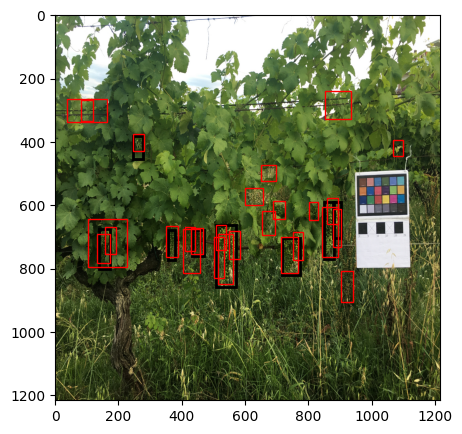

In [23]:
img, target = dataset_test[20]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(DEVICE)])[0]


print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.3)

plot_img_bbox(img, target, nms_prediction)